In [3]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [5]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        dX = dout @ W.T # vanilla Backprop
#         dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward include in dcross_entropy
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            loss, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_prob = nn.test(X_test)
        loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [6]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.2957 valid loss: 2.2889, valid accuracy: 0.1218
Iter-20 train loss: 2.3067 valid loss: 2.2858, valid accuracy: 0.1278
Iter-30 train loss: 2.2777 valid loss: 2.2829, valid accuracy: 0.1356
Iter-40 train loss: 2.3021 valid loss: 2.2799, valid accuracy: 0.1424
Iter-50 train loss: 2.2783 valid loss: 2.2771, valid accuracy: 0.1492
Iter-60 train loss: 2.2632 valid loss: 2.2742, valid accuracy: 0.1542
Iter-70 train loss: 2.2405 valid loss: 2.2714, valid accuracy: 0.1600
Iter-80 train loss: 2.2952 valid loss: 2.2685, valid accuracy: 0.1676
Iter-90 train loss: 2.2804 valid loss: 2.2657, valid accuracy: 0.1776
Iter-100 train loss: 2.2326 valid loss: 2.2629, valid accuracy: 0.1836
Iter-110 train loss: 2.2565 valid loss: 2.2601, valid accuracy: 0.1898
Iter-120 train loss: 2.2466 valid loss: 2.2571, valid accuracy: 0.1970
Iter-130 train loss: 2.2573 valid loss: 2.2542, valid accuracy: 0.2056
Iter-140 train loss: 2.2800 valid loss: 2.2515, valid accuracy: 0.2144
Iter-150 train 

Iter-1170 train loss: 1.9941 valid loss: 1.9664, valid accuracy: 0.5752
Iter-1180 train loss: 2.0257 valid loss: 1.9637, valid accuracy: 0.5770
Iter-1190 train loss: 1.9478 valid loss: 1.9608, valid accuracy: 0.5776
Iter-1200 train loss: 1.9399 valid loss: 1.9580, valid accuracy: 0.5782
Iter-1210 train loss: 1.9699 valid loss: 1.9553, valid accuracy: 0.5786
Iter-1220 train loss: 1.9354 valid loss: 1.9524, valid accuracy: 0.5788
Iter-1230 train loss: 1.9082 valid loss: 1.9495, valid accuracy: 0.5794
Iter-1240 train loss: 1.9829 valid loss: 1.9466, valid accuracy: 0.5792
Iter-1250 train loss: 1.9499 valid loss: 1.9438, valid accuracy: 0.5802
Iter-1260 train loss: 1.9274 valid loss: 1.9409, valid accuracy: 0.5808
Iter-1270 train loss: 2.0122 valid loss: 1.9382, valid accuracy: 0.5808
Iter-1280 train loss: 1.9460 valid loss: 1.9353, valid accuracy: 0.5822
Iter-1290 train loss: 1.8948 valid loss: 1.9324, valid accuracy: 0.5822
Iter-1300 train loss: 1.9766 valid loss: 1.9297, valid accuracy:

Iter-2310 train loss: 1.6960 valid loss: 1.6463, valid accuracy: 0.6274
Iter-2320 train loss: 1.6532 valid loss: 1.6437, valid accuracy: 0.6274
Iter-2330 train loss: 1.7049 valid loss: 1.6410, valid accuracy: 0.6276
Iter-2340 train loss: 1.6249 valid loss: 1.6383, valid accuracy: 0.6274
Iter-2350 train loss: 1.6310 valid loss: 1.6357, valid accuracy: 0.6282
Iter-2360 train loss: 1.6148 valid loss: 1.6331, valid accuracy: 0.6280
Iter-2370 train loss: 1.5903 valid loss: 1.6305, valid accuracy: 0.6284
Iter-2380 train loss: 1.6522 valid loss: 1.6279, valid accuracy: 0.6280
Iter-2390 train loss: 1.6623 valid loss: 1.6252, valid accuracy: 0.6282
Iter-2400 train loss: 1.7074 valid loss: 1.6226, valid accuracy: 0.6280
Iter-2410 train loss: 1.6295 valid loss: 1.6199, valid accuracy: 0.6284
Iter-2420 train loss: 1.5734 valid loss: 1.6173, valid accuracy: 0.6288
Iter-2430 train loss: 1.6861 valid loss: 1.6148, valid accuracy: 0.6286
Iter-2440 train loss: 1.6356 valid loss: 1.6121, valid accuracy:

Iter-3450 train loss: 1.4242 valid loss: 1.3781, valid accuracy: 0.6730
Iter-3460 train loss: 1.4321 valid loss: 1.3761, valid accuracy: 0.6728
Iter-3470 train loss: 1.3528 valid loss: 1.3741, valid accuracy: 0.6732
Iter-3480 train loss: 1.2436 valid loss: 1.3721, valid accuracy: 0.6730
Iter-3490 train loss: 1.3748 valid loss: 1.3701, valid accuracy: 0.6732
Iter-3500 train loss: 1.4648 valid loss: 1.3681, valid accuracy: 0.6742
Iter-3510 train loss: 1.5095 valid loss: 1.3660, valid accuracy: 0.6746
Iter-3520 train loss: 1.3750 valid loss: 1.3640, valid accuracy: 0.6756
Iter-3530 train loss: 1.3333 valid loss: 1.3620, valid accuracy: 0.6752
Iter-3540 train loss: 1.4141 valid loss: 1.3601, valid accuracy: 0.6756
Iter-3550 train loss: 1.4074 valid loss: 1.3583, valid accuracy: 0.6756
Iter-3560 train loss: 1.3940 valid loss: 1.3564, valid accuracy: 0.6764
Iter-3570 train loss: 1.4152 valid loss: 1.3545, valid accuracy: 0.6770
Iter-3580 train loss: 1.3476 valid loss: 1.3526, valid accuracy:

Iter-4590 train loss: 1.2027 valid loss: 1.1817, valid accuracy: 0.7174
Iter-4600 train loss: 1.1818 valid loss: 1.1803, valid accuracy: 0.7180
Iter-4610 train loss: 1.2222 valid loss: 1.1787, valid accuracy: 0.7180
Iter-4620 train loss: 1.2072 valid loss: 1.1773, valid accuracy: 0.7186
Iter-4630 train loss: 1.1297 valid loss: 1.1759, valid accuracy: 0.7190
Iter-4640 train loss: 1.1183 valid loss: 1.1745, valid accuracy: 0.7196
Iter-4650 train loss: 1.1320 valid loss: 1.1731, valid accuracy: 0.7198
Iter-4660 train loss: 1.1746 valid loss: 1.1717, valid accuracy: 0.7208
Iter-4670 train loss: 1.2234 valid loss: 1.1703, valid accuracy: 0.7210
Iter-4680 train loss: 1.1216 valid loss: 1.1689, valid accuracy: 0.7216
Iter-4690 train loss: 1.2800 valid loss: 1.1675, valid accuracy: 0.7218
Iter-4700 train loss: 1.1717 valid loss: 1.1660, valid accuracy: 0.7214
Iter-4710 train loss: 1.2463 valid loss: 1.1646, valid accuracy: 0.7222
Iter-4720 train loss: 1.2279 valid loss: 1.1632, valid accuracy:

Iter-5730 train loss: 1.2062 valid loss: 1.0349, valid accuracy: 0.7570
Iter-5740 train loss: 0.9522 valid loss: 1.0337, valid accuracy: 0.7574
Iter-5750 train loss: 1.0707 valid loss: 1.0327, valid accuracy: 0.7578
Iter-5760 train loss: 1.0131 valid loss: 1.0316, valid accuracy: 0.7580
Iter-5770 train loss: 0.8913 valid loss: 1.0305, valid accuracy: 0.7590
Iter-5780 train loss: 0.9841 valid loss: 1.0293, valid accuracy: 0.7596
Iter-5790 train loss: 1.0314 valid loss: 1.0282, valid accuracy: 0.7600
Iter-5800 train loss: 0.9429 valid loss: 1.0270, valid accuracy: 0.7602
Iter-5810 train loss: 1.0353 valid loss: 1.0258, valid accuracy: 0.7606
Iter-5820 train loss: 0.9655 valid loss: 1.0247, valid accuracy: 0.7604
Iter-5830 train loss: 1.0411 valid loss: 1.0236, valid accuracy: 0.7616
Iter-5840 train loss: 1.0041 valid loss: 1.0225, valid accuracy: 0.7616
Iter-5850 train loss: 0.9357 valid loss: 1.0214, valid accuracy: 0.7620
Iter-5860 train loss: 1.1138 valid loss: 1.0202, valid accuracy:

Iter-6870 train loss: 0.8697 valid loss: 0.9185, valid accuracy: 0.7916
Iter-6880 train loss: 1.0834 valid loss: 0.9175, valid accuracy: 0.7916
Iter-6890 train loss: 0.8235 valid loss: 0.9167, valid accuracy: 0.7920
Iter-6900 train loss: 0.9203 valid loss: 0.9157, valid accuracy: 0.7920
Iter-6910 train loss: 1.0455 valid loss: 0.9148, valid accuracy: 0.7922
Iter-6920 train loss: 0.8940 valid loss: 0.9139, valid accuracy: 0.7914
Iter-6930 train loss: 1.0712 valid loss: 0.9129, valid accuracy: 0.7918
Iter-6940 train loss: 0.8535 valid loss: 0.9121, valid accuracy: 0.7918
Iter-6950 train loss: 0.8210 valid loss: 0.9111, valid accuracy: 0.7926
Iter-6960 train loss: 0.9145 valid loss: 0.9103, valid accuracy: 0.7928
Iter-6970 train loss: 0.9724 valid loss: 0.9093, valid accuracy: 0.7930
Iter-6980 train loss: 1.0111 valid loss: 0.9084, valid accuracy: 0.7928
Iter-6990 train loss: 1.0004 valid loss: 0.9076, valid accuracy: 0.7934
Iter-7000 train loss: 0.9602 valid loss: 0.9067, valid accuracy:

Iter-8010 train loss: 0.7535 valid loss: 0.8233, valid accuracy: 0.8202
Iter-8020 train loss: 0.9395 valid loss: 0.8225, valid accuracy: 0.8200
Iter-8030 train loss: 1.0033 valid loss: 0.8218, valid accuracy: 0.8202
Iter-8040 train loss: 0.7778 valid loss: 0.8210, valid accuracy: 0.8202
Iter-8050 train loss: 0.9007 valid loss: 0.8203, valid accuracy: 0.8206
Iter-8060 train loss: 0.9216 valid loss: 0.8195, valid accuracy: 0.8208
Iter-8070 train loss: 0.8014 valid loss: 0.8188, valid accuracy: 0.8206
Iter-8080 train loss: 0.7222 valid loss: 0.8180, valid accuracy: 0.8206
Iter-8090 train loss: 0.7300 valid loss: 0.8172, valid accuracy: 0.8208
Iter-8100 train loss: 0.9657 valid loss: 0.8165, valid accuracy: 0.8216
Iter-8110 train loss: 0.9094 valid loss: 0.8157, valid accuracy: 0.8216
Iter-8120 train loss: 1.0399 valid loss: 0.8150, valid accuracy: 0.8220
Iter-8130 train loss: 0.8624 valid loss: 0.8143, valid accuracy: 0.8226
Iter-8140 train loss: 0.9508 valid loss: 0.8136, valid accuracy:

Iter-9150 train loss: 0.8259 valid loss: 0.7443, valid accuracy: 0.8374
Iter-9160 train loss: 0.8290 valid loss: 0.7437, valid accuracy: 0.8374
Iter-9170 train loss: 0.9413 valid loss: 0.7431, valid accuracy: 0.8374
Iter-9180 train loss: 0.8234 valid loss: 0.7426, valid accuracy: 0.8374
Iter-9190 train loss: 0.6386 valid loss: 0.7420, valid accuracy: 0.8376
Iter-9200 train loss: 0.6487 valid loss: 0.7414, valid accuracy: 0.8378
Iter-9210 train loss: 0.8677 valid loss: 0.7408, valid accuracy: 0.8380
Iter-9220 train loss: 0.7443 valid loss: 0.7401, valid accuracy: 0.8380
Iter-9230 train loss: 0.9077 valid loss: 0.7396, valid accuracy: 0.8384
Iter-9240 train loss: 0.7423 valid loss: 0.7389, valid accuracy: 0.8378
Iter-9250 train loss: 0.9006 valid loss: 0.7383, valid accuracy: 0.8386
Iter-9260 train loss: 0.6967 valid loss: 0.7377, valid accuracy: 0.8384
Iter-9270 train loss: 0.7671 valid loss: 0.7372, valid accuracy: 0.8384
Iter-9280 train loss: 0.6890 valid loss: 0.7366, valid accuracy:

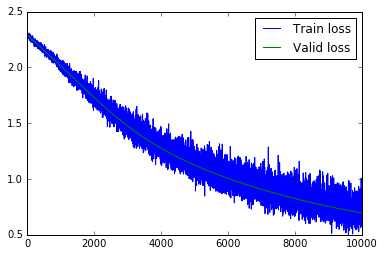

In [7]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

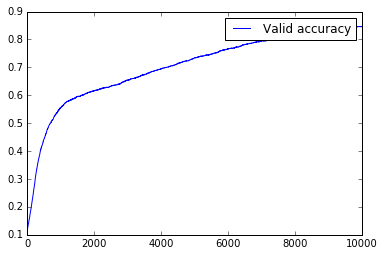

In [8]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()